In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Polinomios Autoregresivos (Modelo ARX)

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas. Usando el modelo ARX:

![OL_LTID2](figuras/lti_arx.png)

Usando el modelo de ecuación de error tenemos que:

$$y[k] = -a_1y[k-1]-...-a_{n_a}y[k-{n_a}] + b_1u[k-1]+b_2u[k-2]+...+b_{n_b}u[k-{n_b}] + e[k]$$

El objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_1, b_2,...,b_{n_b}]^T$. Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[k] = \phi.\theta + e[k]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&u[k-2]&...&u[k-{n_b}]\end{bmatrix}$$

Recordar que del error se pueden introducir los polinomios autoregresivos del modelo ARX:

$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$

$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

Reorganizando entonces:

$$y[k]= \frac{B[z]}{A[z]}u[k] + \frac{1}{A[z]}e[k]$$

$$y[k] = G_e(z)u[k] + H_e(z)e[k]$$

El problema evidente en obtener estas funciones de transferencia estimadas es que se desconoce la naturaleza de la señal $e[k]$, por tanto la señal estimada se debe reconstruir a partir de la función G estimada y el escalón de entrada.

## Ejemplo 1:

Un sistema de segundo orden en tiempo continuo se modela por la siguiente función de transferencia:

$$G(s) = \frac{6}{2s^2+3s+9}$$

En un experimento de laboratorio se obtiene su respuesta al escalo unitario con un sensor obteniendo un conjunto de valores $y_n$

Utilice el modelo ARX para determinar una función de transferencia estimada así:

$$G_e(z) = \frac{B(z)}{A(z)}$$



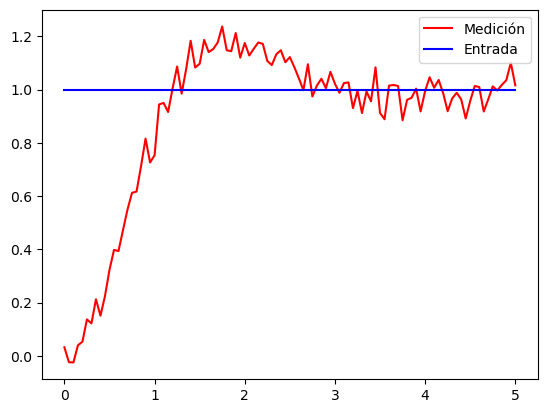

In [15]:
## Sistema de segundo orden en tiempo continuo
#g = control.tf([6],[2,3,9])

g = control.tf([4],[1,2,4])

## Periodo de muestreo y num de muestras para la discretización de la respuesta al escalón
t0 = 0
tf = 5
dt = 0.05
N = int((tf-t0)/dt)+1
t = np.linspace(t0,tf,N)

# Señal de salida ideal "y" y entrada "u"
_,y = control.step_response(g,t)
u = np.ones(N);

## Ruido para simular la señal de salida capturada "yn"
r = 0.05
e = np.random.normal(0,r,size=N)

yn = y+e
plt.plot(t,yn,color = 'red')
plt.plot(t,u,color = 'blue')
plt.legend(['Medición','Entrada'])


## Definir la matriz de regresión

Para estimar el modelo se debe usar la matriz de regresión lineal, involucrando estados anteriores de la salida y de la entrada.
$$\phi = \begin{bmatrix}-y[k-1]&u[k-1]&u[k-2]&u[k-3]\end{bmatrix}$$

In [16]:
## Definir y_1, y_2, y_3, dependiendo el sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
y_4 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)
for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=y[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=y[k-3]
    u_3[k]=u[k-3]
for k in range(4,N):
    y_4[k]=y[k-4]
    
## Creación del vector phi
phi = np.array([-y_1,u_1,u_2,u_3]).transpose()
##phi = np.array([-y_1,-y_2,u_1]).transpose()

## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$

La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad. Existirán tantos parámetros como columnas tenga la matriz de regresión.

In [17]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.9220904 , -0.05351428,  0.05052801,  0.08461222])

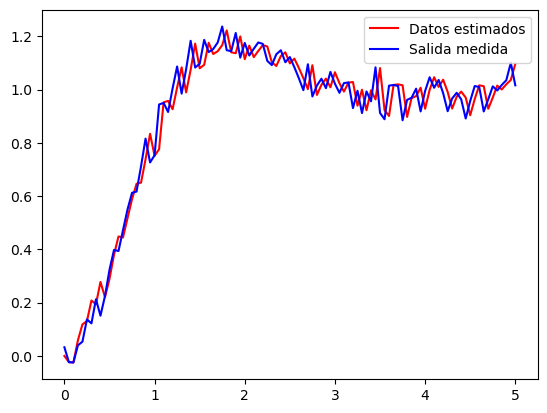

In [18]:
##Reconstrucción de los datos estimados

ye1 = np.dot(phi,theta)
## Graficando las funciones
plt.plot(t,ye1,color = 'red')
plt.plot(t,yn,color = 'blue')

plt.legend(['Datos estimados','Salida medida'])

## Determinando los polinomios autoregresivos
$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$
$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

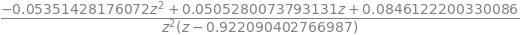

In [19]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)
s = sym.symbols('s', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 
B = theta[1]*z**-1+theta[2]*z**-2+theta[3]*z**-3

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()

H = 1/A
H = H.simplify()

G

## Construir la función estimada en tiempo discreto
$$G_e(z)=\frac{B(z)}{A(z)} = \frac{b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-n_b}}{1+a_1z^{-1}+...+a_{n_a}z^{-n_a}}$$

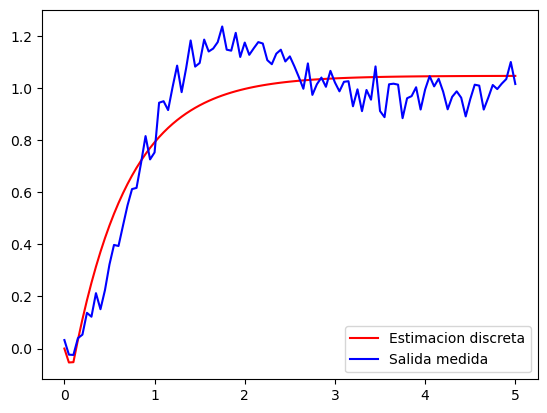

In [21]:
## Se crea el sistema estimado
G_e = control.tf([theta[1],theta[2],theta[3]],[1,theta[0],0,0],dt)

## Se determina la respuesta estimada al escalón
_,ye = control.step_response(G_e,t)
###  Ganancia de ajuste
k = 1
ye = k*ye

### Función ideal, discretizando el sistema original para comparar funciones

gd = control.c2d(g,dt)
_,yd = control.step_response(gd,t)

## Graficando las funciones
plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'blue')

plt.legend(['Estimacion discreta','Salida medida'])
#plt.xlim([0, t[len(t)-1]])   

ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)

In [22]:
## Función de transferencia estimada G(z), FT ideal y error cuadratico medio 
print(G_e)
print(gd)
print(ECM)


-0.05351 z^2 + 0.05053 z + 0.08461
----------------------------------
         z^3 - 0.9221 z^2

dt = 0.05


0.004833 z + 0.004675
----------------------
z^2 - 1.895 z + 0.9048

dt = 0.05

0.011335227320762416


(array([0.9220904+0.j, 0.       +0.j, 0.       +0.j]),
 array([ 1.81522588+0.j, -0.8710292 +0.j]))

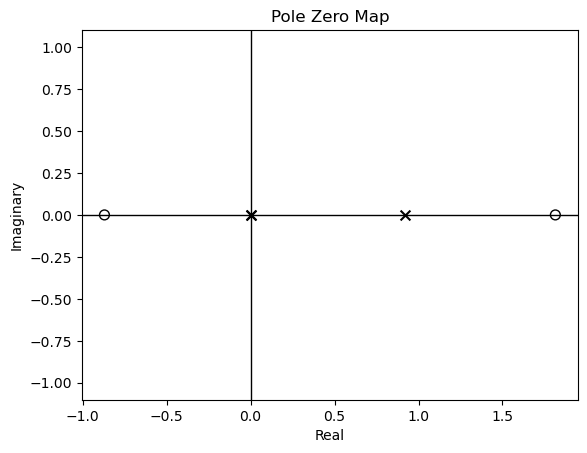

In [23]:
control.pzmap(G_e)

(array([0.94766454+0.08227595j, 0.94766454-0.08227595j]),
 array([-0.96720774+0.j]))

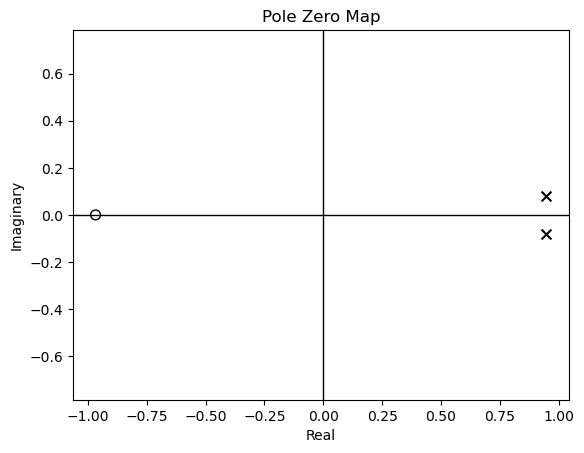

In [24]:
control.pzmap(gd)

# Estimación en tiempo continuo

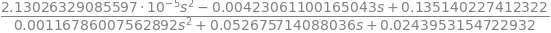

In [25]:
#Reescribiendo al tiempo continuo haciendo 
#el reemplazo manual de z en función de S

z = (1+dt/2*s)/(1-dt/2*s)
A = z**2 + theta[0]*z + theta[1] 
B = theta[2]*z+theta[3]
Gc = B/A
Gc = Gc.simplify();

Gc

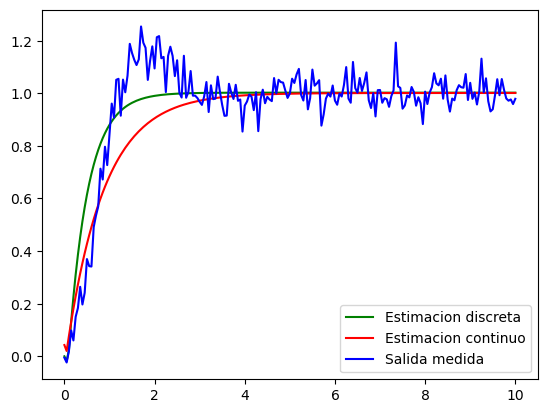

In [14]:
## Creando la función de transferencia estimada
## Deben cambiarse por los coeficientes de la salida del bloque anterior

sys = control.tf([1.2360358523722e-5,-0.00304503350783705,0.102024766675527],
                 [0.000288632412374423,0.085906992265301,0.101908449588883])

_,ye1 = control.step_response(sys,t)

## Graficando las funciones
plt.plot(t,ye,color = 'green')
plt.plot(t,ye1,color = 'red')
plt.plot(t,yn,color = 'blue')

plt.legend(['Estimacion discreta','Estimacion continuo','Salida medida'])
